# Introduction
In this notebook, we discuss how to implement and solve the time-dependent Schrödinger equation
\begin{equation}
\partial_t |\psi(t)\rangle = -i H(t) |\psi(t)\rangle
\end{equation}
for a few simple cases. We assume that the time-dependent Hamiltonian has the form $H(t) = H_0 + F(t) H_I$, where $F(t)$ is a time-dependent function (not an operator), while $H_I$ is a time-independent operator describing the interaction with the field (e.g., for length-gauge, we have $F(t) = -E(t)$ and $H_I = \hat{\mu}$). The general idea is to express the wave function in a basis expansion,
\begin{equation}
|\psi(t)\rangle = \sum_k \psi_k(t) |k\rangle,
\end{equation}
where the basis functions $|k\rangle$ are chosen in a "smart" way (and are time-independent) so as to make the numerics as efficient as possible, and the time-dependent coefficients correspond to the overlap between the wave function and basis function $k$, i.e., $\psi_k(t) = \langle k|\psi(t)\rangle$. Inserting the basis expansion in the Schrödinger equation and multiplying with another basis state $\langle j|$ from the left then yields
\begin{equation}
\partial_t \sum_k \psi_k(t) \langle j|k\rangle = -i \sum_k \langle j|H(t)|k\rangle \psi_k(t)
\end{equation}

We assume that we have chosen a set of orthonormal basis states, $\langle j|k\rangle = \delta_{jk}$ where $\delta_{jk}$ is the Kronecker delta ($=1$ if $j=k$, and $=0$ otherwise). This means that on the left, the only term in the sum that is nonzero is for $j=k$ (note that this is not a necessary condition - e.g., in a B-spline basis, this is not the case). On the right, $\langle j|H(t)|k\rangle = H_{jk}(t) = H_{0,jk} + F(t) H_{I,jk}$ are matrix elements that depend on time (but note that the time-dependence is only in the factor $F(t)$). We thus have
\begin{equation}
\partial_t \psi_j(t) = -i \sum_k H_{jk}(t) \psi_k(t)
\end{equation}
which is a system of coupled linear differential equations. It can be rewritten more compactly by defining the coefficient vector $\vec{\psi}(t) = (\psi_1(t), \psi_2(t), \ldots)^T$ and the matrix $\mathbf{H}(t)$ (we will use the convention that bold symbols denote matrices) with matrix elements $H_{jk}$, and realizing that the right-hand side corresponds to a matrix-vector multiplication. This gives simply
\begin{align}
\partial_t \vec{\psi}(t) &= -i \mathbf{H}(t) \vec{\psi}(t)\\
\partial_t \vec{\psi}(t) &= -i (\mathbf{H}_0 + F(t) \mathbf{H}_I) \vec{\psi}(t),
\end{align}
which is the equation we will solve.

## Choice of basis
The final form for the time-dependent Schrödinger equation gives an indication of the "wishlist" for our choice of numerical basis $|k\rangle$. Ideally, we want
1. A compact basis with as few functions as possible to reach convergence (so the vectors and matrices are small).
2. A basis for which the matrix elements $H_{jk}$ are easy/cheap to calculate.
3. A basis in which the obtained matrices $\mathbf{H}_0$ and $\mathbf{H}_I$ are "sparse", i.e., as many elements as possible are zero.

Note that point 3 is typically **not** fulfilled by using the eigenbasis of $H_0$ - in that basis, $\mathbf{H}_0$ is diagonal (i.e., as sparse as possible), but $\mathbf{H}_I$ is usually quite dense (as dipole transitions are possible between any two states for which they are symmetry-allowed). However, the eigenbasis (if available) often allows for the most compact representation (see point 1), as only states that are physically involved in the dynamics need to be included. In the extreme limit, this can be only two states (e.g., for a laser that is resonant with the $1s-2p$ transition in the hydrogen atom and not too strong).

## Time propagation
Once a basis has been chosen and the matrices $\mathbf{H}_0$ and $\mathbf{H}_I$ have been calculated, we need to solve the differential equation, i.e., propagate the solution in time from the initial value $\vec{\psi}(t_0)$ to the final time to obtain $\vec{\psi}(t_f)$. There are many available algorithms for such problems. A simple and versatile option are general solvers for ordinary differential equations, as implemented, e.g., in the [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function (which supports several different solvers with different characteristics).

Another option are methods that rely on the fact that $F(t)$ can be approximated as constant on short enough time intervals $\delta t$. In that case, the equation has the formal solution $\vec{\psi}(t+\delta t) = e^{-i H(t) \delta t} \vec{\psi}(t)$, and several methods exist to efficiently approximate the matrix exponential (or more specifically, the matrix-exponential vector product $e^{-i H(t) \delta t} \vec{\psi}(t)$) for short intervals $\delta t$. We will in the following use one such method, the so-called "short iterative Lanczos" propagator (see chapter 4.2 in https://johannesfeist.eu/pubs/phd.pdf for details and references), which calculates the exponential in a Krylov basis spanned by the vectors $\{\vec{\psi}(t), H(t) \vec{\psi}(t), H(t)^2 \vec{\psi}(t), \ldots, H(t)^n \vec{\psi}(t)\}$ for some small number $n$ (typically of the order 15 or so). A Python implementation of this is available in the [`jftools`](https://github.com/jfeist/jftools) package.

## Extraction of observables
After time propagation, we need to obtain the observables we are interested in. This can be, e.g., the spatial wave function itself, the remaining population in the ground state, the photo-electron spectrum, or similar things. In general, the calculation of such observables can be highly nontrivial, especially for complex targets like many-electron atoms or molecules.

# Model
For concreteness, we will solve the dynamics of a one-dimensional model atom, in which a single electron is restricted to move in a single dimension $x$. We use Hartree atomic units, in which $\hbar=m_e=4\pi\epsilon_0=e=1$, and work in length gauge, such that $F(t) = E(t)$ and $H_I = -\hat{\mu} = -q_e x = x$ (since an electron has charge $q_e=-e$).
The Hamiltonian is then given by
\begin{align}
H_0 &= \frac12 p_x^2 + V(x) = -\frac12 \frac{\partial^2}{\partial x^2} + V(x)\\
H_I &= x
\end{align}
For the 1D hydrogen atom with an electron moving along the $x$ axis, the potential should be $V(x) = -1/|x|$. However, the singularity at the origin leads to diverging results when the motion of the electron is restricted to one dimension. This is "cured" by using a "soft Coulomb potential" $V(x) = -1/\sqrt{a^2 + x^2}$, where $a$ is a constant parametrizing the "lateral extension" of the electron. For $a=\sqrt{2}$ (in atomic units), the ground-state energy $E_0 = -1/2$ Hartree in the soft Coulomb potential is equal to the one of the real (3D) hydrogen atom. We will thus use that value below.

## Spatial grid
For general situations where many states are expected to be populated, direct expansion in a spatial basis can be useful. In the following, we will use a so-called Finite-Element Discrete Variable Representation (FEDVR) to expand the behavior in $x$ (see chapter 4.1 in https://johannesfeist.eu/pubs/phd.pdf for details and references). In the FEDVR, the $x$-axis is split into "finite elements", and within each element, a high-order polynomial basis is used within a so-called Discrete Variable Representation (FEDVR). This basis has several advantageous features:
1. Being a relatively high-order method, the number of required basis functions is typically much smaller than in standard finite-difference approaches.
2. There exists a set of points $x_j$ where all basis functions apart from a single one are equal to zero, $\langle x_j | k\rangle = \delta_{jk} / \sqrt{w_k}$, where $\sqrt{w_k}$ is a weight coefficient that appears because the basis functions are normalized, $\langle k|k\rangle = 1$. This makes it trivial to obtain the value of the wave function in space at the points $x_j$, since $\psi(x_j,t) = \langle x_j | \psi(t)\rangle = \sum_k \psi_k(t) \langle x_j | k\rangle = \psi_j(t) / \sqrt{w_j}$.
3. The representation of derivative operators $\langle j|\frac{\partial^2}{\partial x^2}|k\rangle$ is quite sparse, in particular it consists of overlapping $n\times n$ diagonal blocks, where $n$ is the order used for the DVR within each finite element. Furthermore any spatial operators such as the dipole operator ($x$ itself) and potential $V(x)$ are represented by diagonal matrices, $V_{jk}(x) = \delta_{jk} V(x_j)$ (this is not exact, but a very good approximation).

A Python implementation of the FEDVR grid is available in the [`jftools`](https://github.com/jfeist/jftools) package as well.

# Setup
In the following, we import the required packages and define a class "H1D_simulation" that we will use to perform all the simulations. It provides a self-contained object to perform time propagation of the 1D atom with an arbitrary pulse (or collection of pulses), and obtain the final photoelectron spectrum etc. We will again make use of the `laserfields` library to describe the pulses. We also copy the helper function `plot_lf_field_fourier` to plot the fields and their Fourier transforms.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.sparse import diags
from jftools.fedvr import fedvr_grid
from jftools.short_iterative_lanczos import sesolve_lanczos
from laserfields import make_laserfield, au_as, LaserFieldCollection
from copy import copy

In [ ]:
plt.style.use('https://johannesfeist.eu/misc/jf_cb.mplstyle')
plt.rc("font",family='serif')

In [3]:
def plot_lf_field_fourier(lf,ts,ωs,log_four=False,plot_phase=True):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].plot(ts,lf(ts))
    try:
        axs[0].plot(ts,lf.envelope(ts),'C0--')
    except:
        pass
    axs[0].set_xlabel("t (a.u.)")
    axs[0].set_ylabel("E(t) (a.u.)")

    Eω = lf.E_fourier(ωs)
    axs[1].plot(ωs,abs(Eω)**2)
    axs[1].set_xlabel(r"$\omega$ (a.u.)")
    axs[1].set_ylabel(r"$|\tilde{E}(\omega)|^2$ (a.u.)")
    if log_four:
        axs[1].set_ylim(1e-6*abs(Eω).max()**2)
        axs[1].set_yscale("log")
    else:
        axs[1].set_ylim(0,)
    if plot_phase:
        axs = np.r_[axs, axs[1].twinx()]  # instantiate a second axes that shares the same x-axis
        axs[2].plot(ωs,np.angle(Eω)/np.pi,'C1')
        axs[2].set_ylim(-1.05,1.05)
        axs[2].set_ylabel(r"$\arg \tilde{E}(\omega) / \pi$")
    
    for ax in axs:
        ax.autoscale(axis="x",tight=True)

    return fig, axs

In [4]:
def eigh_with_signfix(H):
    vals, vecs = np.linalg.eigh(H)
    # sign of eigenvectors is arbitrary, fix so largest value is positive
    for ii in range(len(vals)):
        v = vecs[:,ii]
        v *= np.sign(v[np.argmax(abs(v))])
    return vals, vecs

In [5]:
class H1D_simulation:
    def __init__(self,grid,a=np.sqrt(2)):
        self.grid = grid
        self.x = grid.x
        self.wt = grid.wt
        self.a = a
        self.V = -1/np.sqrt(self.a**2 + self.x**2)
        # note that for FEDVR grids, grid.dx2 is a sparse matrix representing the d/dx^2 operator
        self.H0 = -grid.dx2/2 + diags(self.V, format='csr')
        self.vals, self.vecs = eigh_with_signfix(self.H0.toarray())

    "this function calculates Hpsi = H(t)*psi"
    def applyHt(self,t,psi,Hpsi):
        Hpsi[:] = self.H0.dot(psi) + self.lf(t)*self.x*psi
        return Hpsi
    
    def run(self,lf,ts,psi0=None):
        self.lf = lf
        self.ts = ts
        if psi0 is None:
            psi0 = self.vecs[:,0]
        self.psi0 = np.asarray(psi0,dtype=complex)
        maxHT = lf.TX / 50
        self.psis = np.array(sesolve_lanczos(self.applyHt,self.psi0,self.ts,12,1e-12,maxHT=maxHT))
        self.c0s = self.psis @ self.psi0
        self.psis_exc = self.psis - self.c0s[:,None] * self.psi0
        self.psif_E = self.vecs.T @ self.psis_exc[-1]
        
    def run_copy(self,lf,ts,psi0=None):
        sol = copy(self)
        sol.run(lf,ts,psi0)
        return sol

In [6]:
xmax = 400.
xelem = 5.
grid = fedvr_grid(15,np.arange(-xmax,xmax+1,xelem))
sim = H1D_simulation(grid)

Creating an instance of the `H1D_simulation` class automatically calculates its eigenstates.

We plot the potential and first few eigenstates.

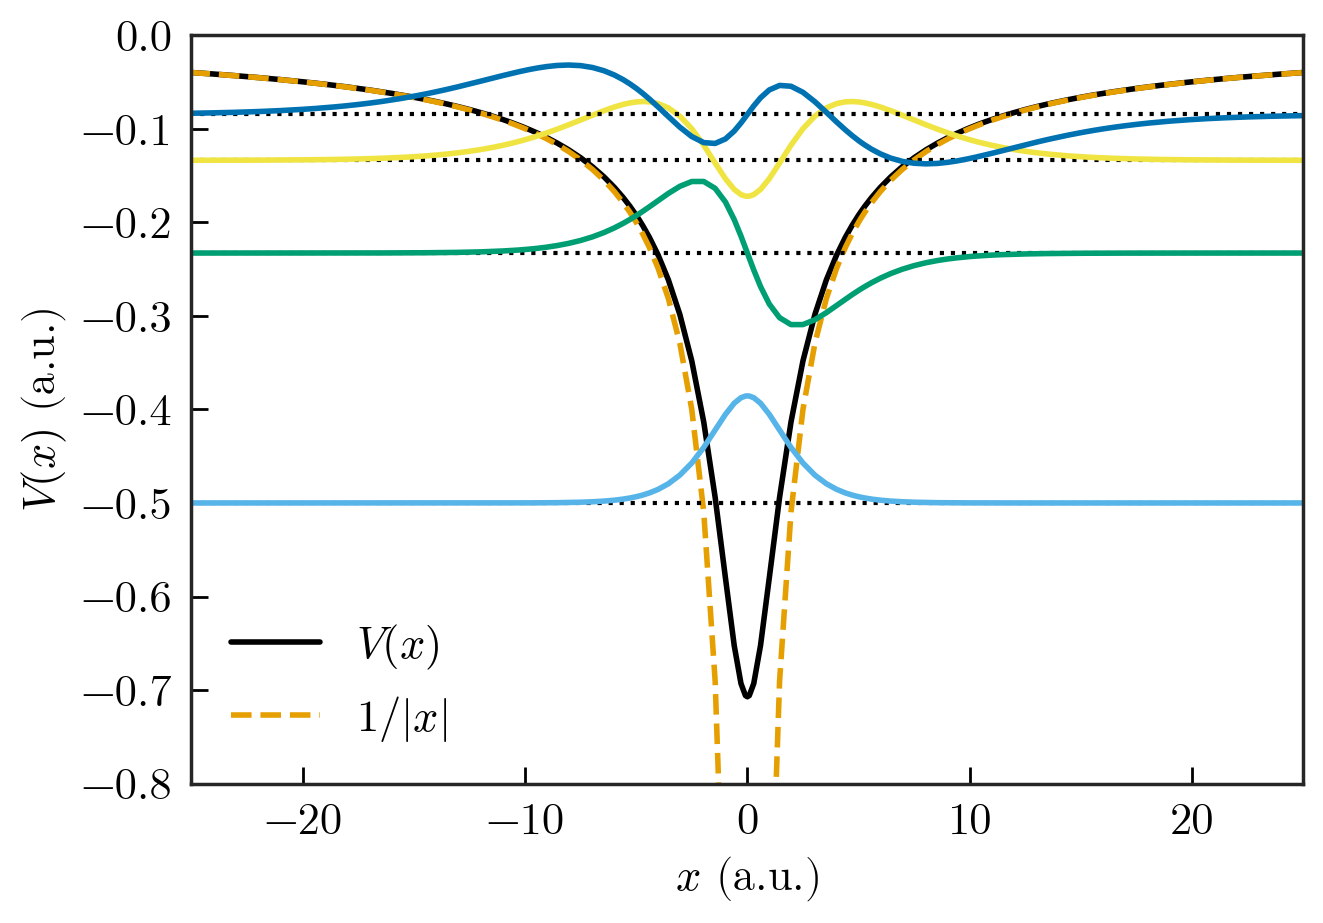

In [7]:
plt.plot(sim.x,sim.V,label=r"$V(x)$")
plt.plot(sim.x,-1/abs(sim.x+1e-19),'--',label=r"$1/|x|$")
for ii in range(4):
    plt.plot(sim.x,sim.vals[ii] + 0*sim.x, 'k:', lw=1.5)
    plt.plot(sim.x,sim.vals[ii] + 0.2*sim.vecs[:,ii]/np.sqrt(sim.wt))

plt.xlim(-25,25)
plt.ylim(-0.8,0)
plt.xlabel(r"$x$ (a.u.)")
plt.ylabel(r"$V(x)$ (a.u.)")
plt.legend();

# Few-photon ionization
Since we now work in atomic units, but want to describe the laser field in "convenient" units, we pass unitful parameters to `make_laserfield`, which automatically get converted to atomic units.
However, we pass the frequency directly in atomic units, choosing a value where the photon energy is just large enough to allow one-photon ionization. 

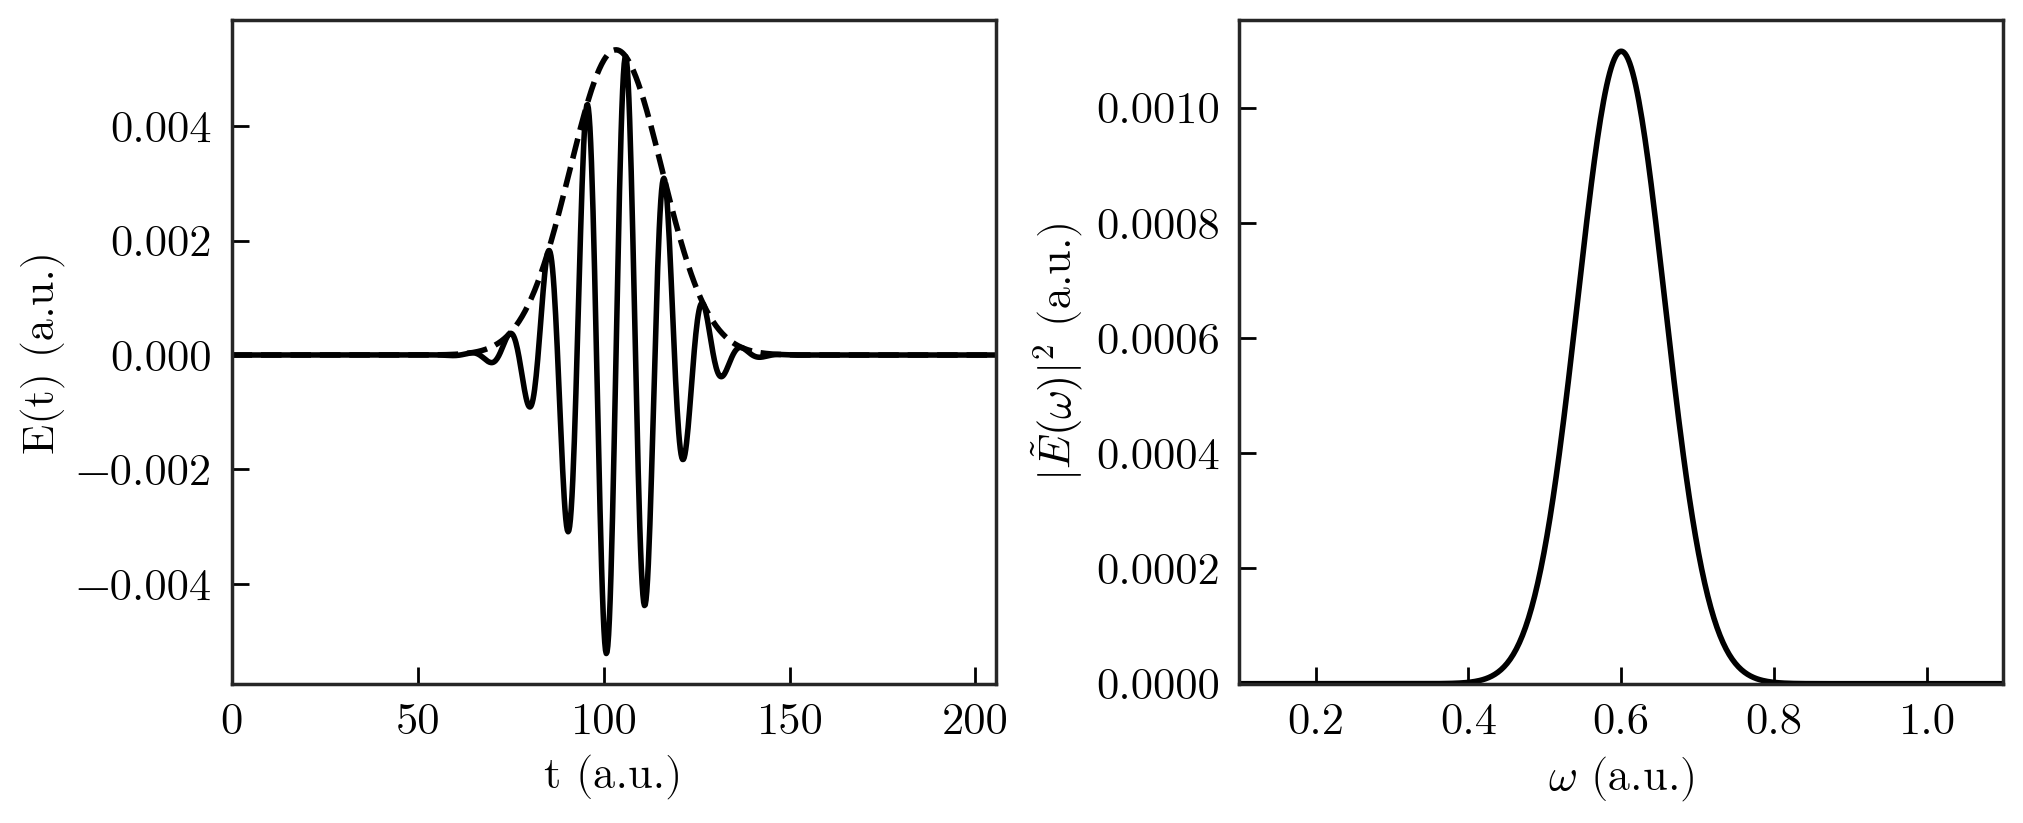

In [8]:
lf = make_laserfield(form="gaussianI", is_vecpot=False, duration_as=500.,
                     intensity_Wcm2=1e12, ω0=0.6, peak_time_as=2500., phase_pi=0)
ts = np.arange(0,lf.end_time,lf.TX/50)
ωs = np.linspace(0.1,1.1,500)
plot_lf_field_fourier(lf,ts,ωs,plot_phase=False);

## run the simulation for three intensities

In [9]:
ts = np.arange(0,250,lf.TX/20)
I_Wcm2s = [1e12,1e14,1e16]
sols = []
for I_Wcm2 in I_Wcm2s:
    lf = make_laserfield(form="gaussianI", is_vecpot=False, duration_as=500.,
                         intensity_Wcm2=I_Wcm2, ω0=0.6, peak_time_as=2500.)
    sols.append(sim.run_copy(lf,ts))

## Plot ground-state population $|c_0(t)|^2$

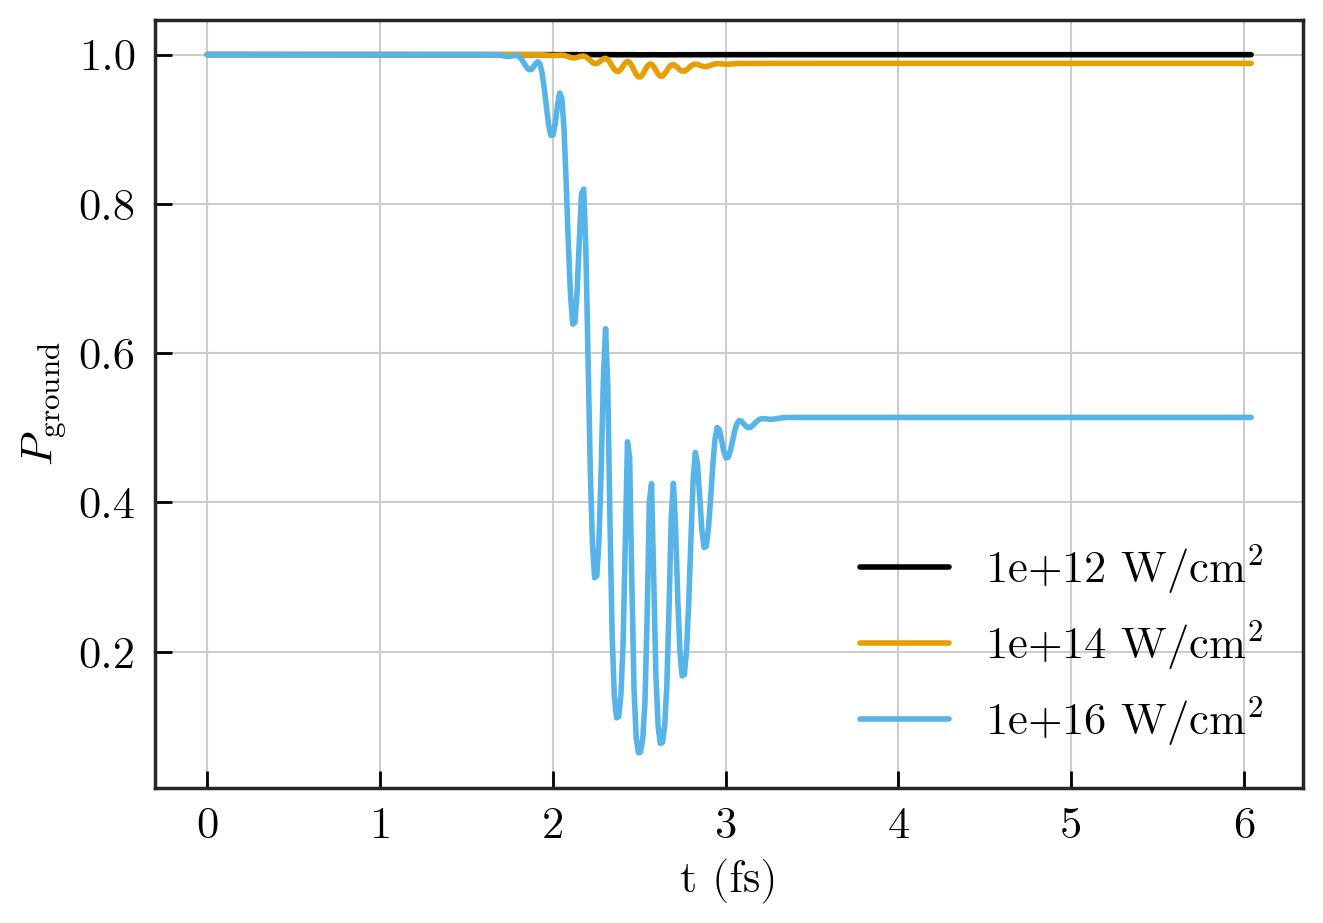

In [10]:
for sol,I_Wcm2 in zip(sols,I_Wcm2s):
    plt.plot(sol.ts/au_as*1e-3, abs(sol.c0s)**2, label=f"{I_Wcm2:g} W/cm$^2$")
plt.legend()
plt.xlabel("t (fs)")
plt.ylabel(r"$P_{\mathrm{ground}}$")
plt.grid();

## Plot spatial wave function $|\psi(x,t)|^2$

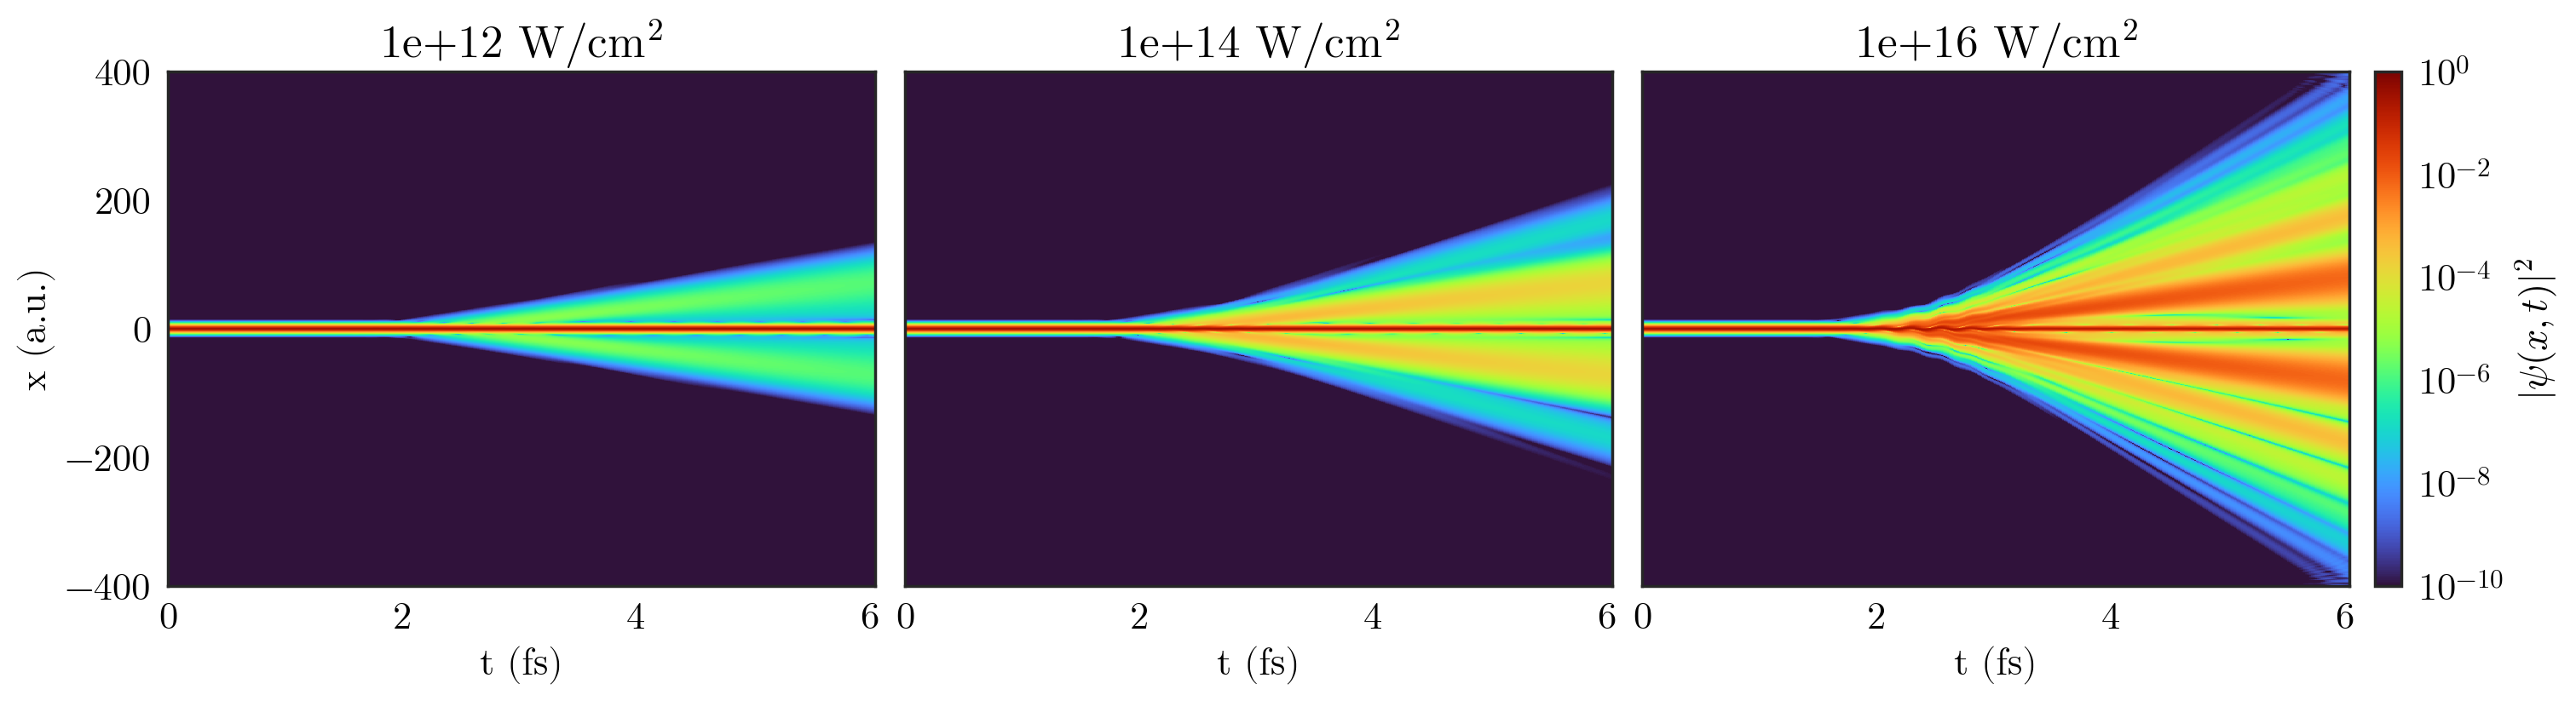

In [11]:
fig, axs = plt.subplots(1,len(I_Wcm2s),figsize=(5*len(I_Wcm2s),4),sharex=True,sharey=True)
for ax,I_Wcm2,sol in zip(axs,I_Wcm2s,sols):
    P = abs(np.array(sol.psis))**2/sol.wt
    im = ax.pcolormesh(sol.ts/au_as*1e-3,sol.x,P.T,norm=mpl.colors.LogNorm(vmin=1e-10,vmax=1))
    ax.set_xlabel("t (fs)")
    ax.set_title(f"{I_Wcm2:g} W/cm$^2$")
axs[0].set_ylabel("x (a.u.)")
cb = plt.colorbar(im,ax=axs,fraction=0.05,pad=0.01);
cb.set_label(r"$|\psi(x,t)|^2$")

## Plot eigenstate populations (~photoelectron spectrum)

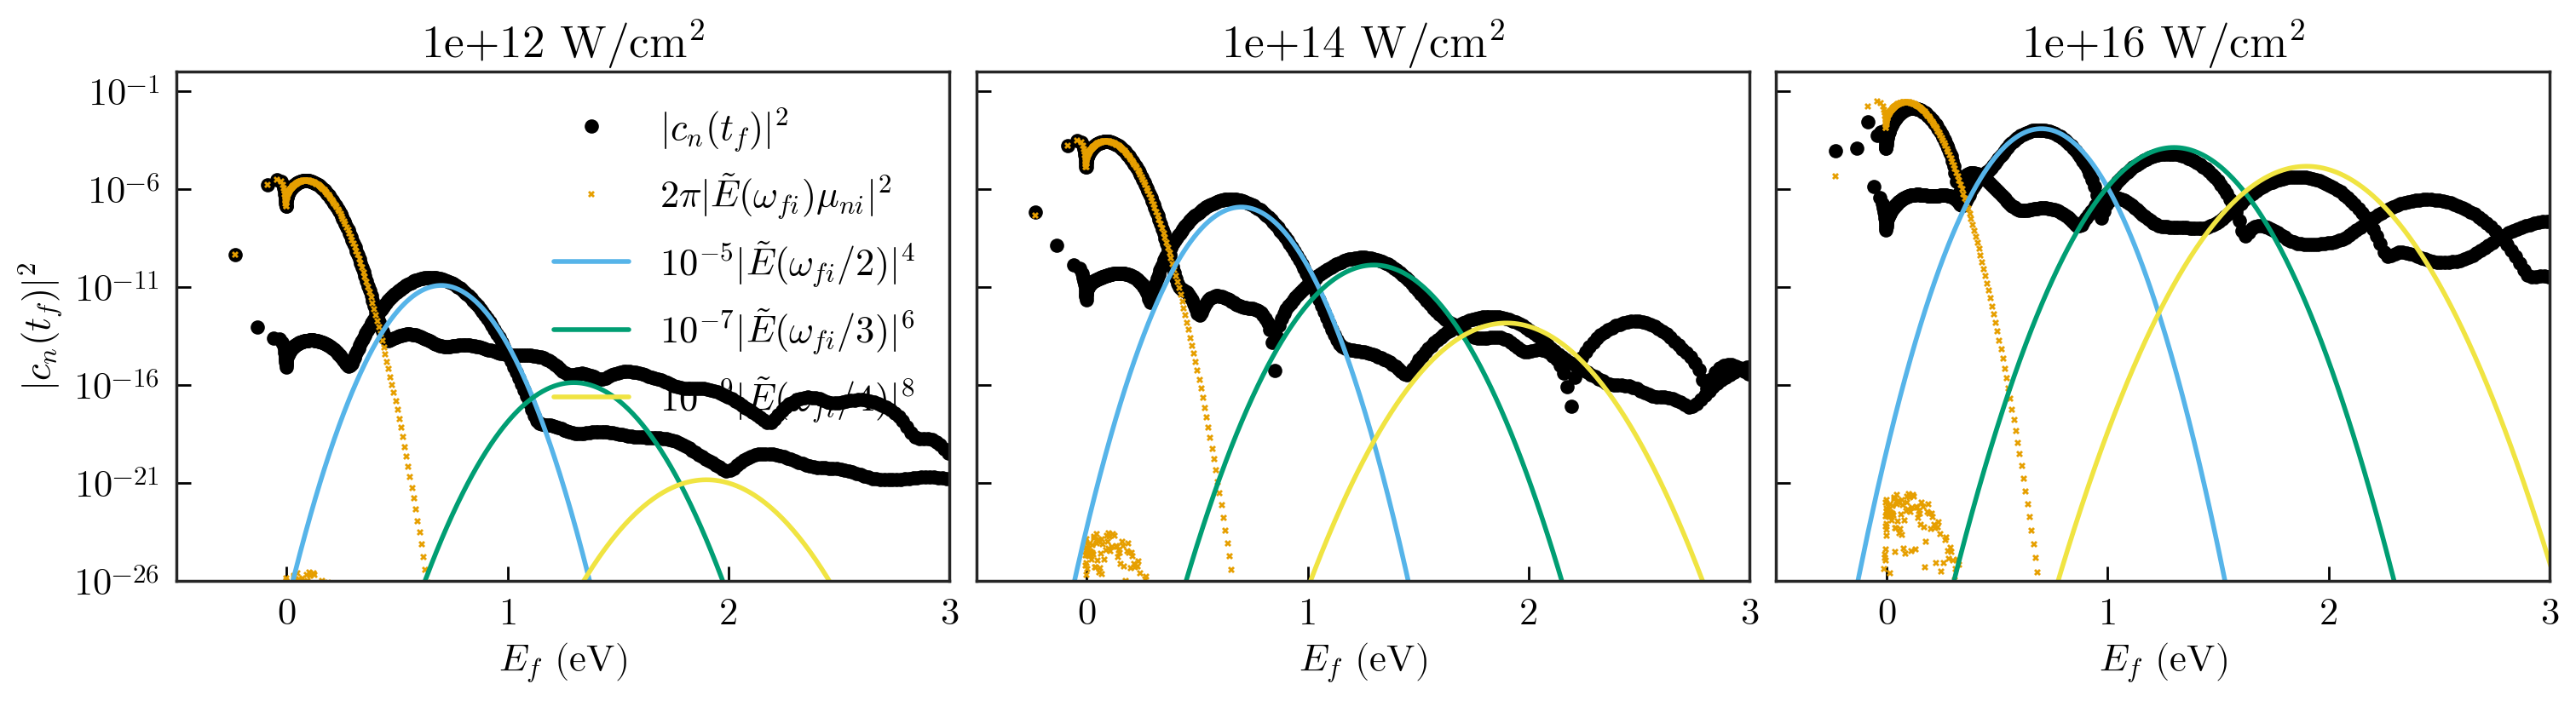

In [12]:
fig, axs = plt.subplots(1,len(I_Wcm2s),figsize=(5*len(I_Wcm2s),4),sharex=True,sharey=True)
for ax,I_Wcm2,sol in zip(axs,I_Wcm2s,sols):
    lf, vals, vecs, psif_E = sol.lf, sol.vals, sol.vecs, sol.psif_E
    μij = vecs.T @ (sol.x[:,None]*vecs)
    ax.plot(vals,abs(psif_E)**2,'o',ms=6,label=r"$|c_n(t_f)|^2$")
    ax.plot(vals,abs(lf.E_fourier(vals-vals[0])*μij[:,0])**2 * 2*np.pi, 'X', ms=3, label=r"$2\pi|\tilde{E}(\omega_{fi}) \mu_{ni}|^2$")
    ax.plot(vals,abs(lf.E_fourier((vals-vals[0])/2))**4 * 1e-5, label=r"$10^{-5}|\tilde{E}(\omega_{fi}/2)|^4$")
    ax.plot(vals,abs(lf.E_fourier((vals-vals[0])/3))**6 * 1e-7, label=r"$10^{-7}|\tilde{E}(\omega_{fi}/3)|^6$")
    ax.plot(vals,abs(lf.E_fourier((vals-vals[0])/4))**8 * 1e-9, label=r"$10^{-9}|\tilde{E}(\omega_{fi}/4)|^8$")
    ax.set_xlabel(r"$E_f$ (eV)")
    ax.set_title(f"{I_Wcm2:g} W/cm$^2$")
axs[0].legend()
axs[0].set_ylabel(r"$|c_n(t_f)|^2$")
axs[0].set_xlim(vals[0],3.)
axs[0].set_ylim(1e-26,1)
axs[0].set_yscale("log")

# Few-level behavior
We now take a pulse on resonance with the transition from the ground state to the first excited state.

[-0.5        -0.23290334]
0.26709666309804925


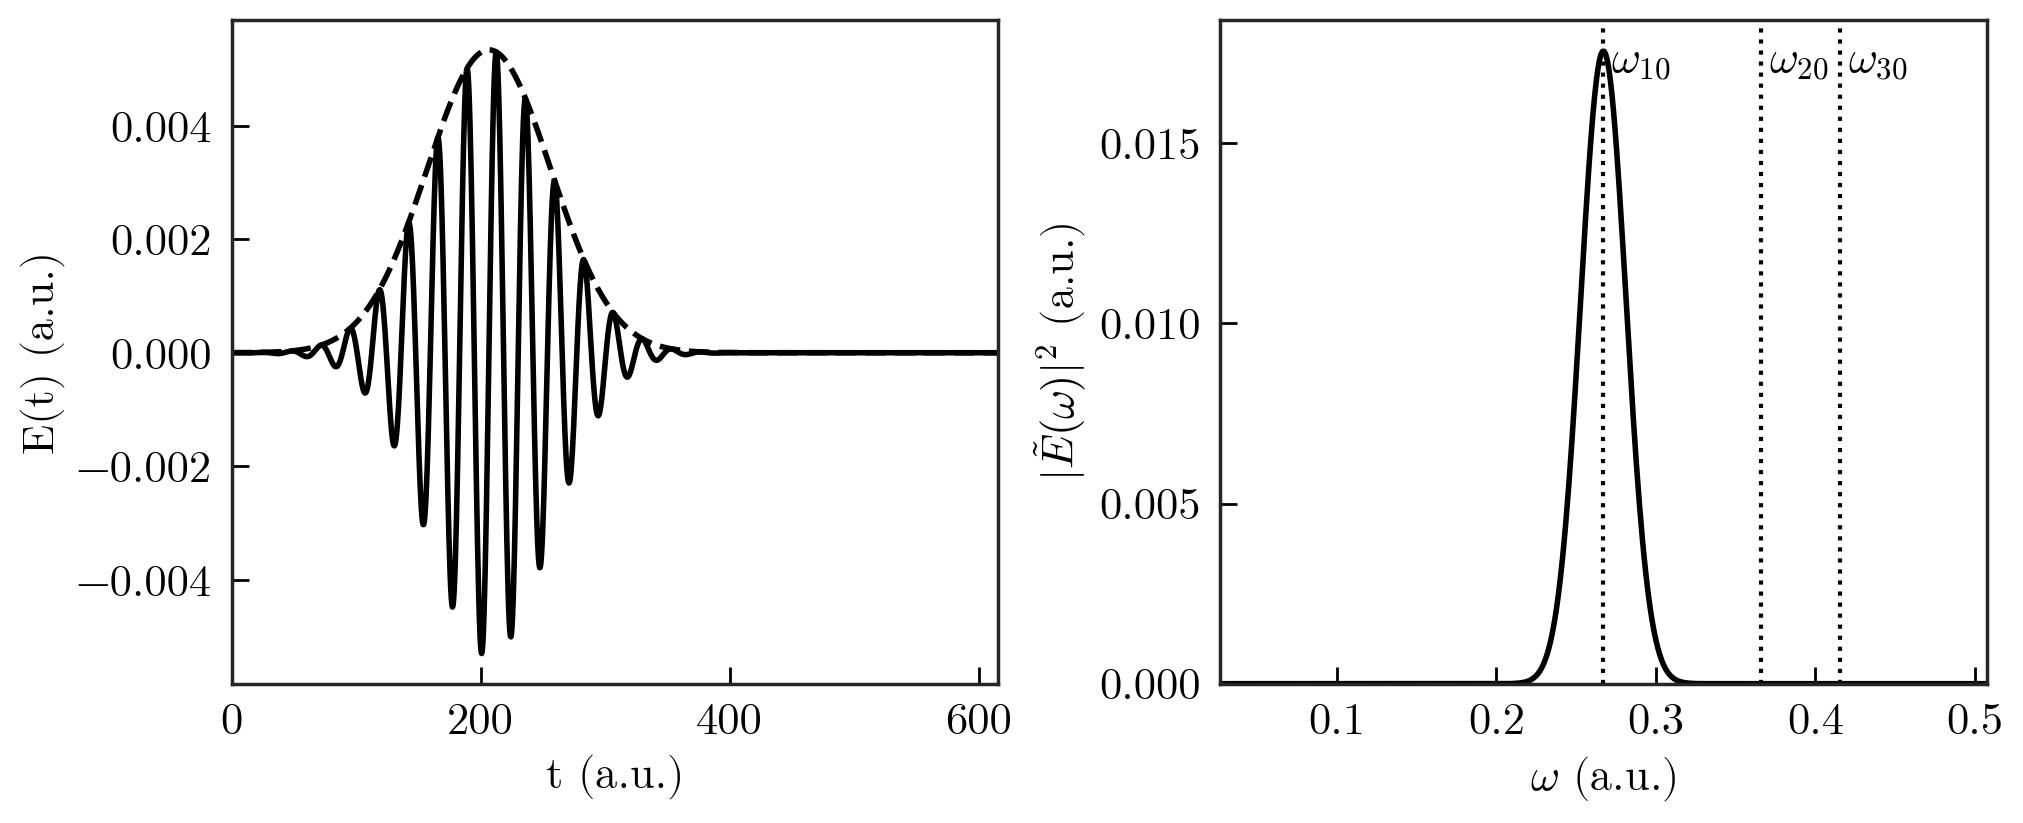

In [13]:
xmax = 50.
xelem = 5.
grid = fedvr_grid(15,np.arange(-xmax,xmax+1,xelem))
sim = H1D_simulation(grid)
print(sim.vals[:2])
ω10 = sim.vals[1] - sim.vals[0]
print(ω10)

lf = make_laserfield(form="gaussianI", is_vecpot=False, ω0=ω10,
                     intensity_Wcm2=1e12, duration_as=2000, peak_time_as=5000)
ts = np.arange(0,lf.end_time,lf.TX/50)
ωs = np.linspace(lf.ω0*0.1,lf.ω0*1.9,500)
fig, axs = plot_lf_field_fourier(lf,ts,ωs,plot_phase=False)
for ii,val in enumerate(sim.vals[1:4],start=1):
    axs[1].axvline(val-sim.vals[0],ls=":",lw=1.5)
    axs[1].text(val-sim.vals[0]+0.005,0.017,fr'$\omega_{{{ii}0}}$')

## run the simulation for three pulse durations

In [14]:
sols = []
for duration_as in 2000,4000,6000:
    lf = make_laserfield(form="gaussianI", is_vecpot=False, ω0=ω10,
                         intensity_Wcm2=1e12, duration_as=duration_as, peak_time_as=2.5*duration_as)
    ts = np.arange(0,lf.end_time,lf.TX/20)
    sols.append(sim.run_copy(lf,ts))

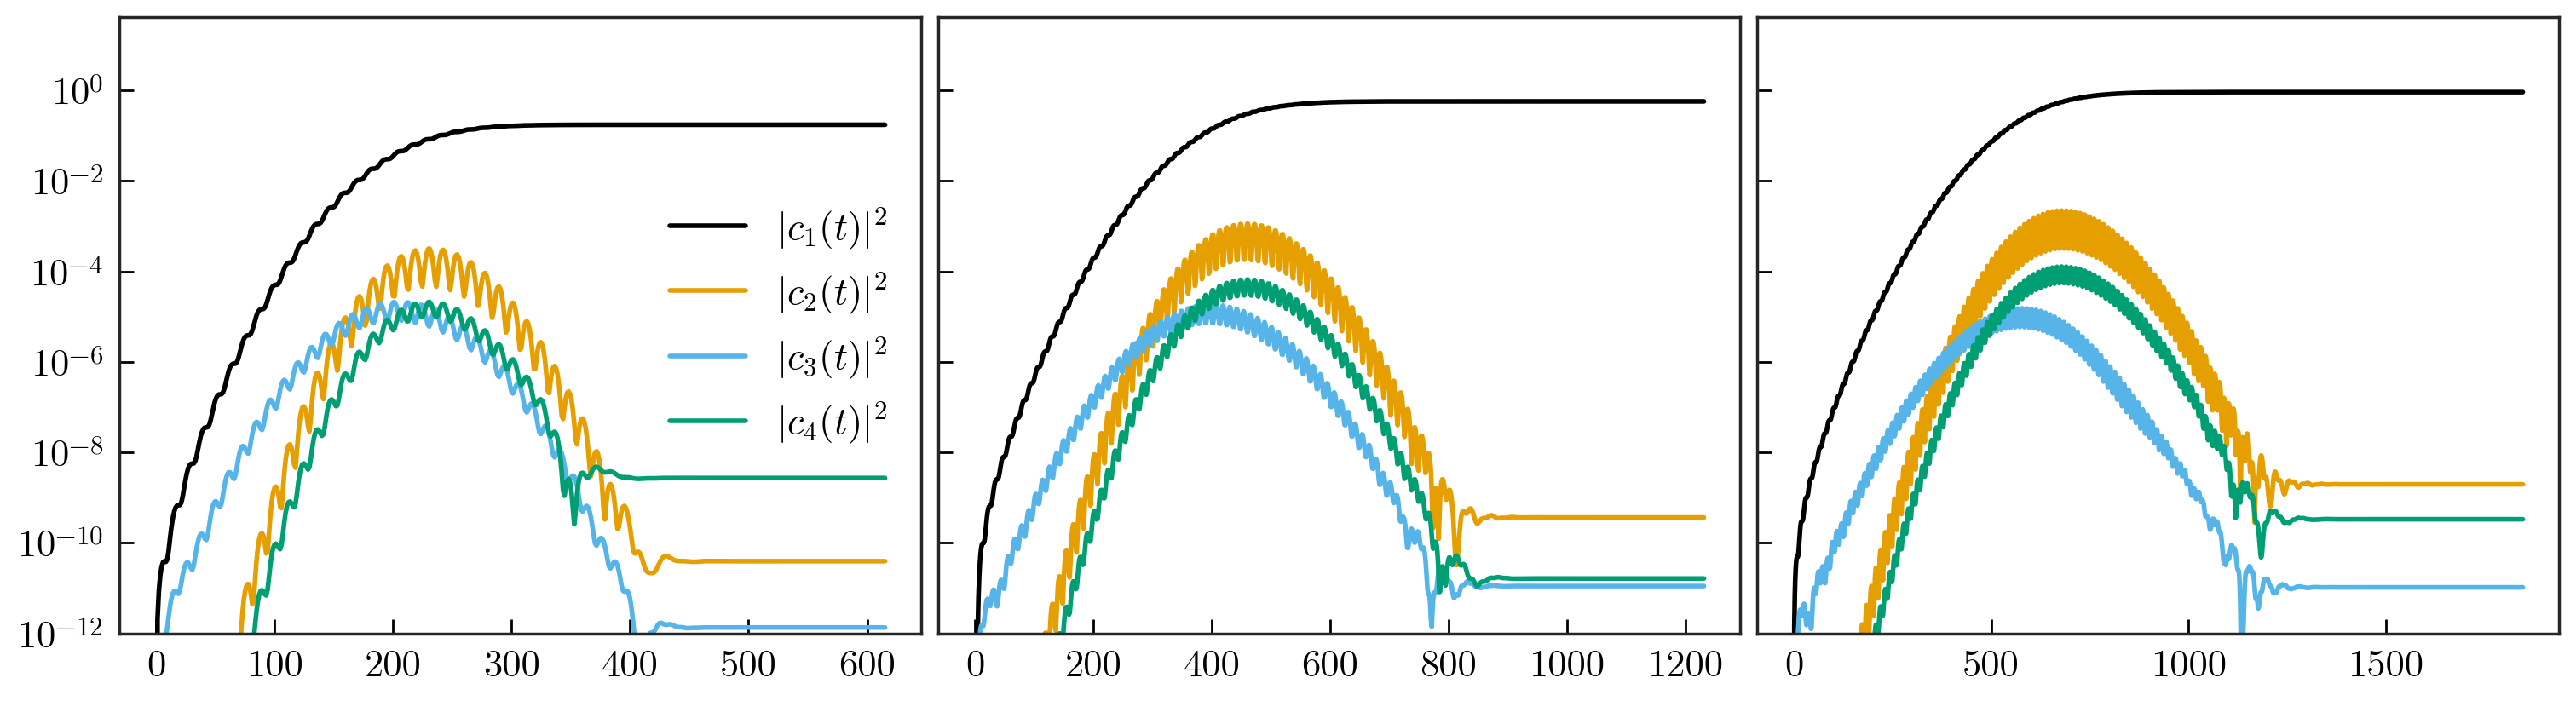

In [15]:
fig, axs = plt.subplots(1,len(sols),figsize=(5*len(sols),4),sharey=True)
for ax,sol in zip(axs,sols):
    for ii in (1,2,3,4):
        ax.plot(sol.ts,abs(sol.psis @ sol.vecs[:,ii])**2,label=rf"$|c_{ii}(t)|^2$")
    ax.set_yscale("log")
axs[0].legend()
axs[0].set_ylim(1e-12,);

## Exercise: Implement propagation within the two-level basis
1. Use the eigenbasis of $H_0$ (tip: eigenenergies are in sim.vals, eigenvectors are in sim.vecs, see above for how to calculate the dipole operator elements) as the basis to express the Hamiltonian for propagation in, and use just the two-level basis containing the ground and first excited state. Ideally, write something like the H1d_simulation class but for a two-level system. **IMPORTANT**: The short iterative Lanczos time propagator does not work for two-level systems. Use an alternative, such as [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). Note that a general differential equation solver such as `solve_ivp` solves the equation $\partial_t \vec{\psi}(t) = \vec{f}(\vec{\psi}(t), t)$, i.e., for the Schrödinger equation, you have to implement $\vec{f}(\vec{\psi}(t), t) = -i (\mathbf{H}_0 + F(t) \mathbf{H}_I) \vec{\psi}(t)$ (which is the same as `applyHt` above apart from an extra prefactor $-i$).

2. Compare the results between this two-level approximation and the "full" simulation when changing the pulse intensity, pulse length, etc. When does it break down?

## Two delayed pulses

[-0.5        -0.23290334]
0.26709666309804925


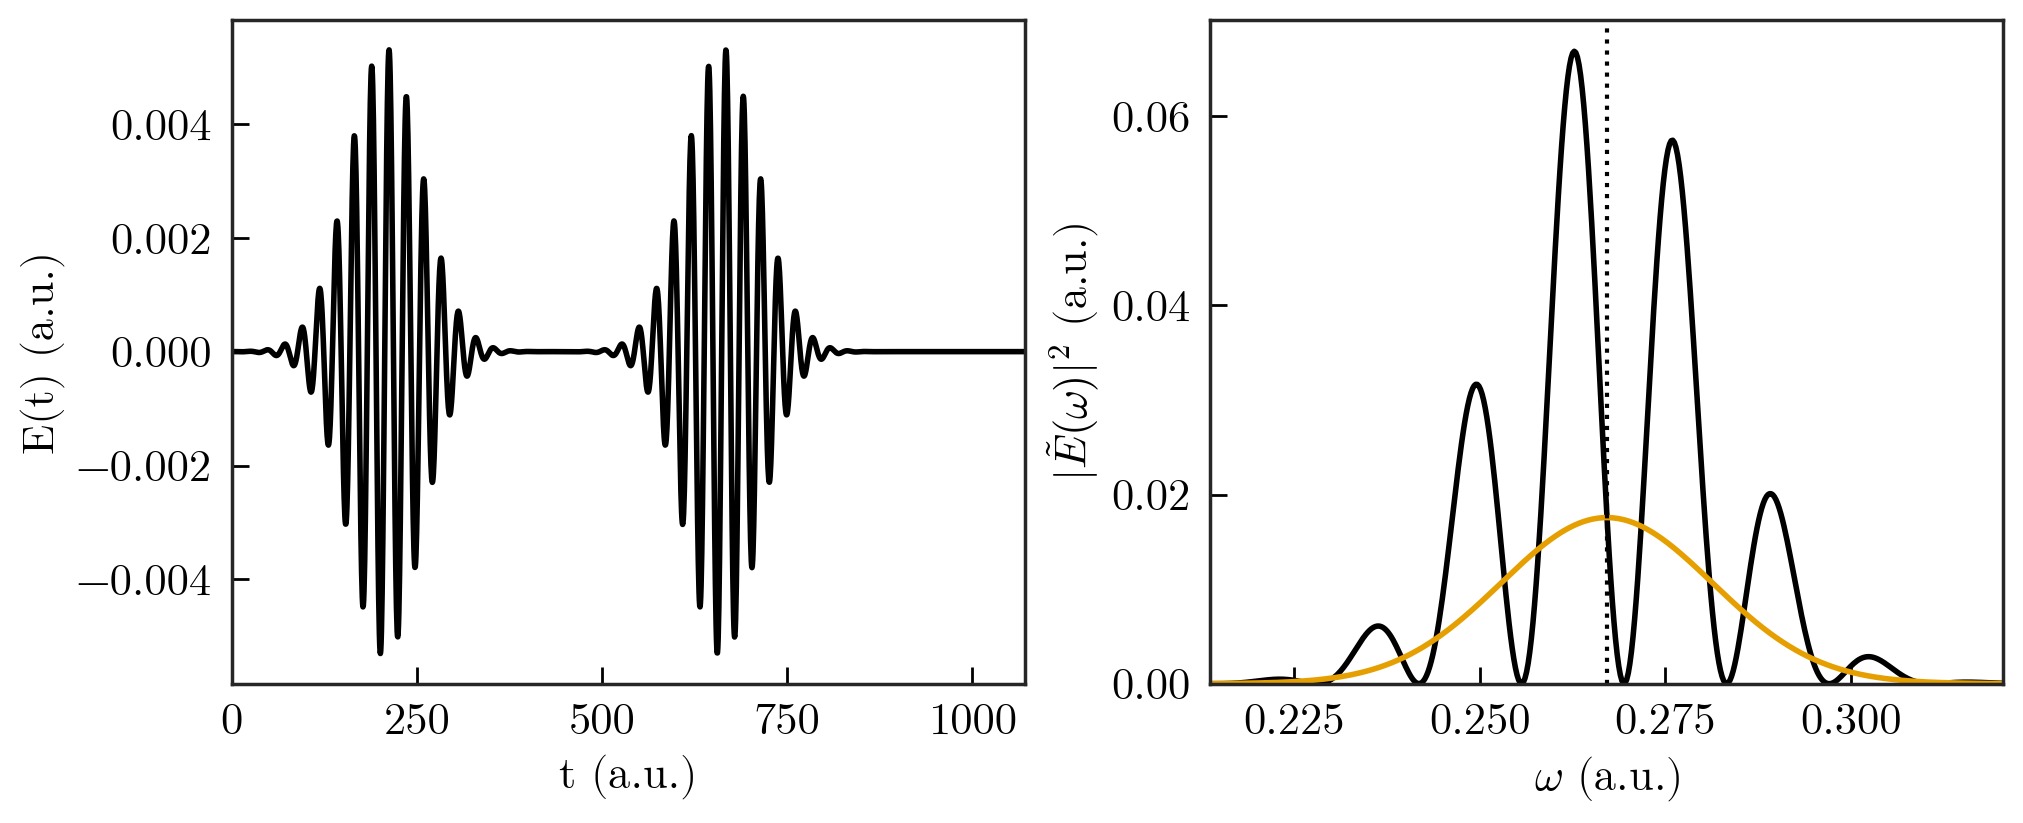

In [16]:
xmax = 50.
xelem = 5.
grid = fedvr_grid(15,np.arange(-xmax,xmax+1,xelem))
sim = H1D_simulation(grid)
print(sim.vals[:2])
ω10 = sim.vals[1] - sim.vals[0]
print(ω10)

lf = LaserFieldCollection([make_laserfield(form="gaussianI", is_vecpot=False, ω0=ω10,
                                           intensity_Wcm2=1e12, duration_as=2000, peak_time_as=5000),
                           make_laserfield(form="gaussianI", is_vecpot=False, ω0=ω10,
                                           intensity_Wcm2=1e12, duration_as=2000, peak_time_as=16000)])
ts = np.arange(0,lf.end_time,lf.TX/50)
ωs = np.linspace(lf.ω0*0.8,lf.ω0*1.2,500)
fig, axs = plot_lf_field_fourier(lf,ts,ωs,plot_phase=False)
axs[1].plot(ωs,abs(lf.lfs[0].E_fourier(ωs))**2)
axs[1].axvline(ω10,ls=":",lw=1.5);

In [17]:
sol = sim.run_copy(lf,ts)

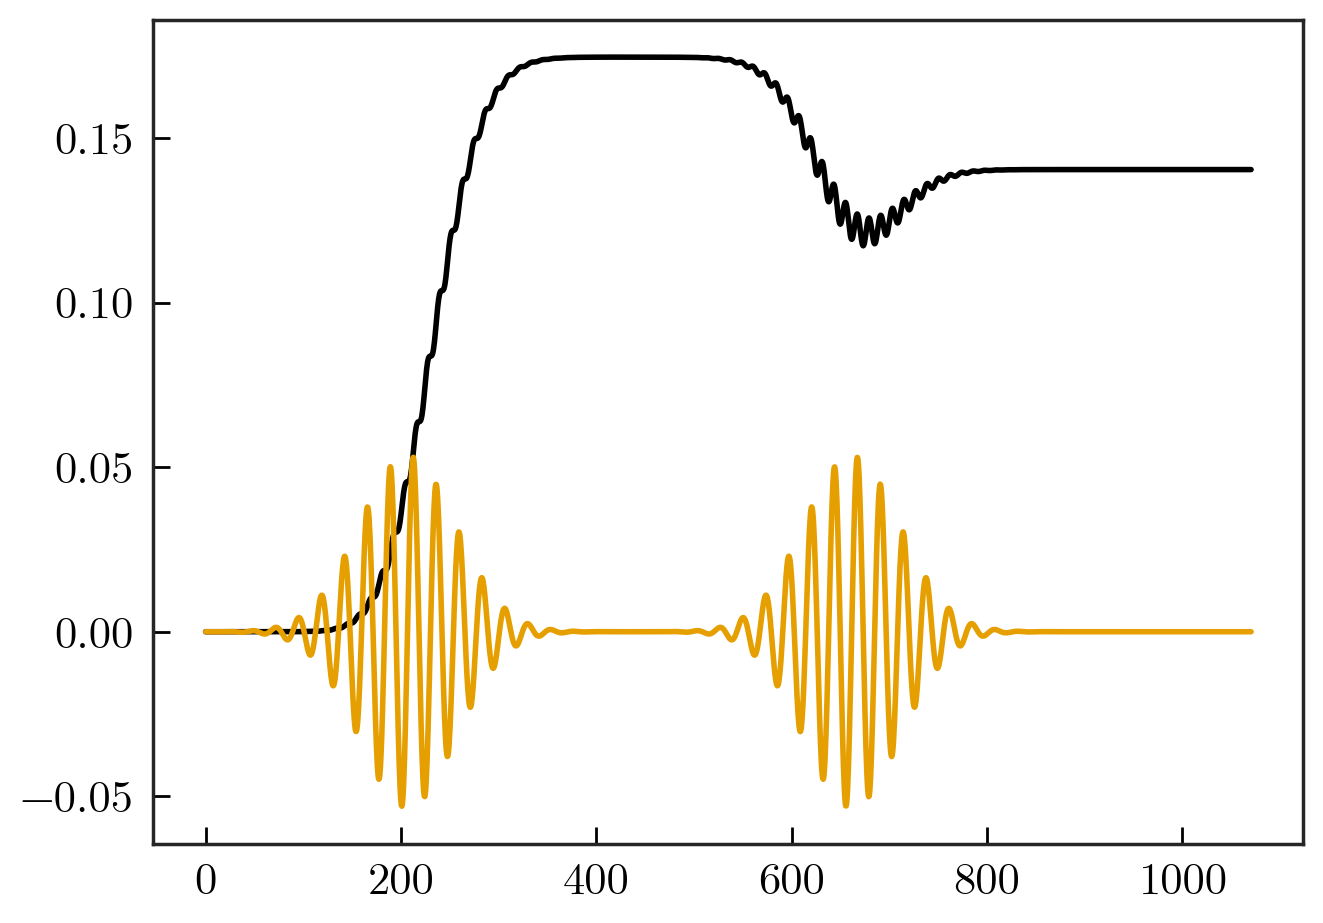

In [18]:
plt.plot(sol.ts,abs(sol.psis @ sol.vecs[:,1])**2,label=r"$|c_1(t)|^2$")
plt.plot(sol.ts,lf(ts)*10, label=r"$10 E(t)$");

## Exercise: 
1. Find a situation with destructive interference where the Fourier transform of the two pulses is (almost) zero at the transition frequency. How does the population behave in time?
2. The inverse: Now look for a situation with perfect constructive interference, i.e., where the transition frequency is at the maximum of a peak in the Fourier spectrum. How does the population behave with time in the pulses? Why?

# High-intensity IR field

0.6588471876267328


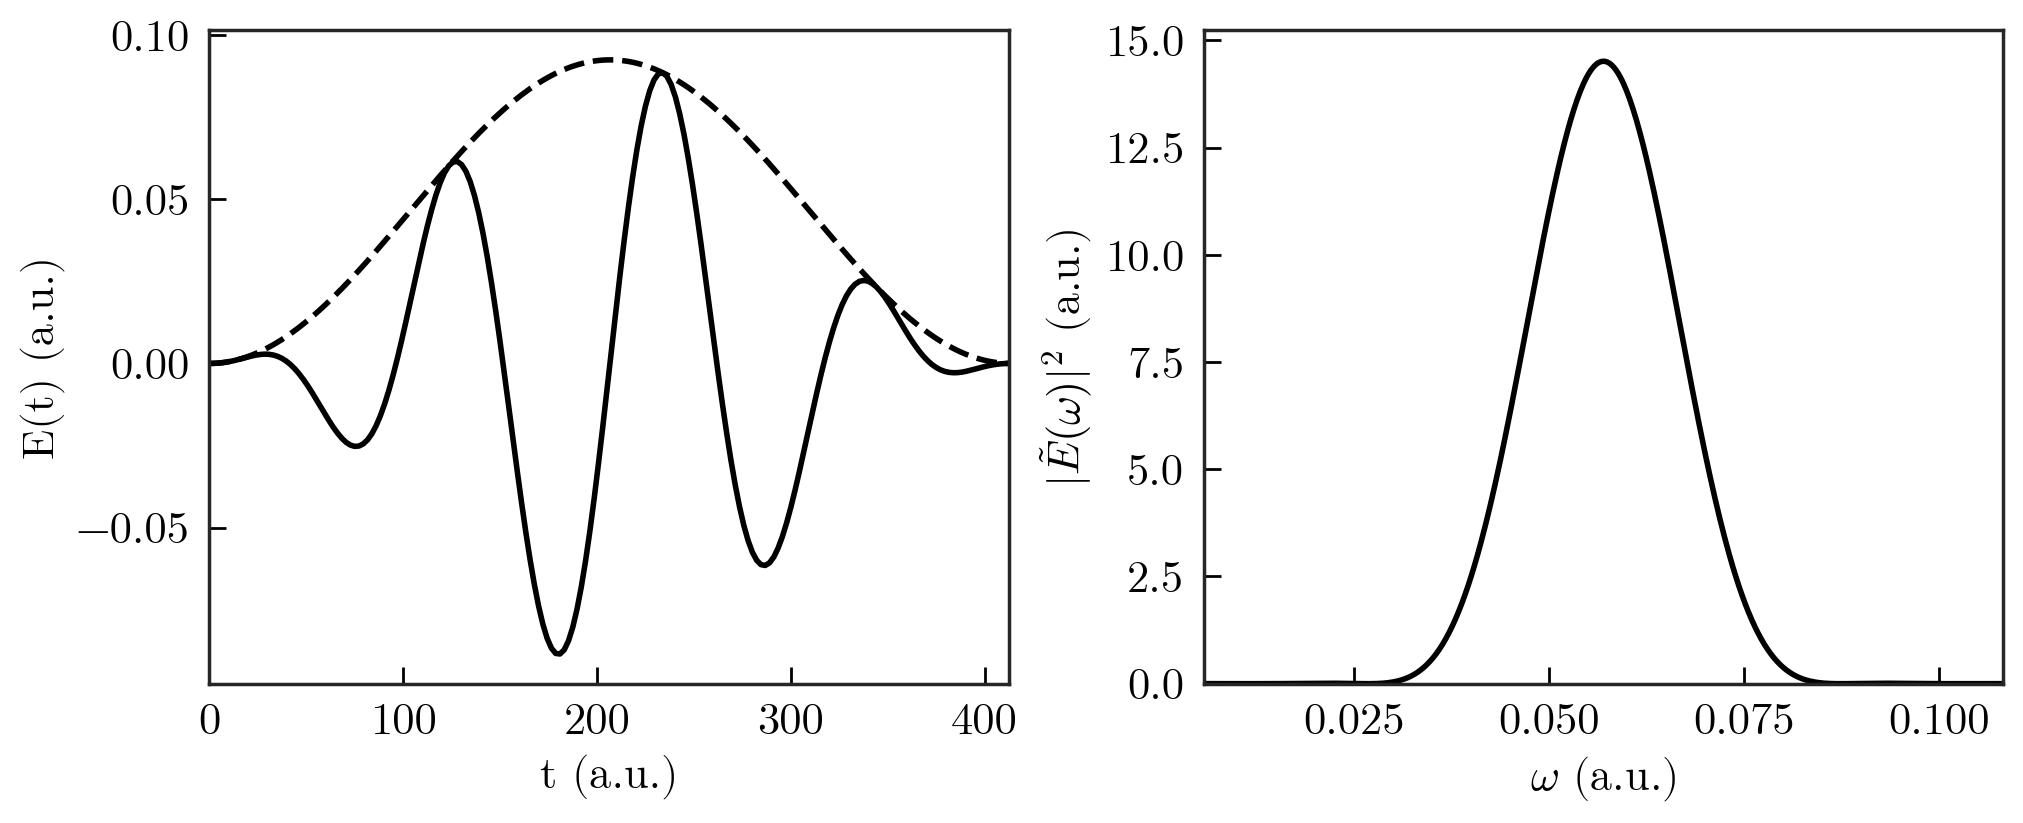

In [19]:
lf = make_laserfield(form="sin2", is_vecpot=False, lambda_nm=800.,
                     intensity_Wcm2=3e14, duration_as=10e3, peak_time_as=5e3)
ts = np.arange(0,lf.end_time,lf.TX/50)
ωs = np.linspace(lf.ω0*0.1,lf.ω0*1.9,500)
plot_lf_field_fourier(lf,ts,ωs,plot_phase=False)

# ponderomotive potential
Up = lf.E0**2 / (4*lf.ω0**2)
print(Up)

In [20]:
xmax = 800.
xelem = 4.
grid = fedvr_grid(14,np.arange(-xmax,xmax+1,xelem))
sim = H1D_simulation(grid)
sol = sim.run_copy(lf,ts)

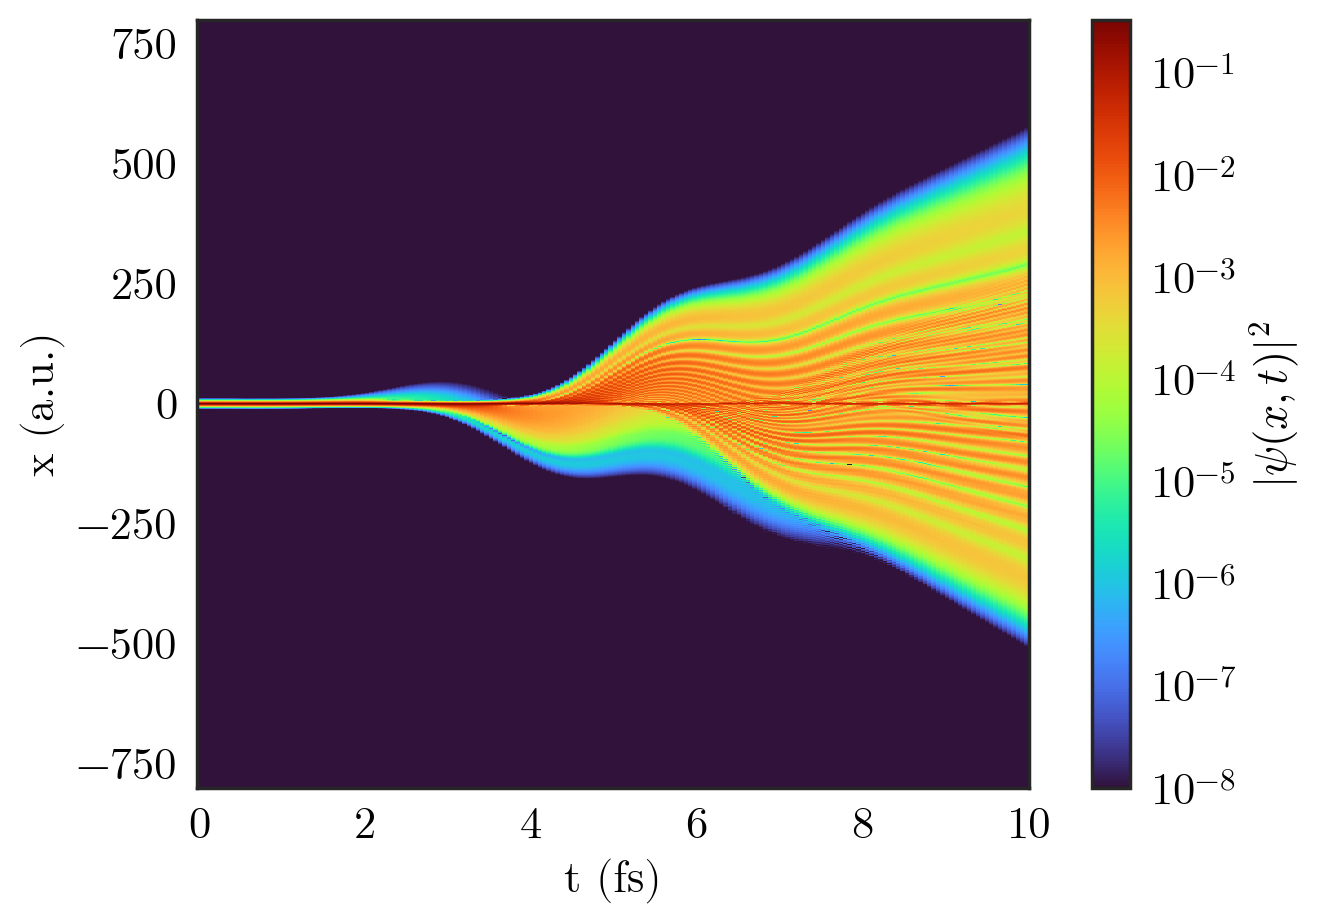

In [21]:
P = abs(sol.psis)**2/sol.wt
plt.pcolormesh(sol.ts/au_as*1e-3,sol.x,P.T,norm=mpl.colors.LogNorm(vmin=1e-8))
cb = plt.colorbar()
cb.set_label(r"$|\psi(x,t)|^2$")
plt.xlabel("t (fs)")
plt.ylabel("x (a.u.)");

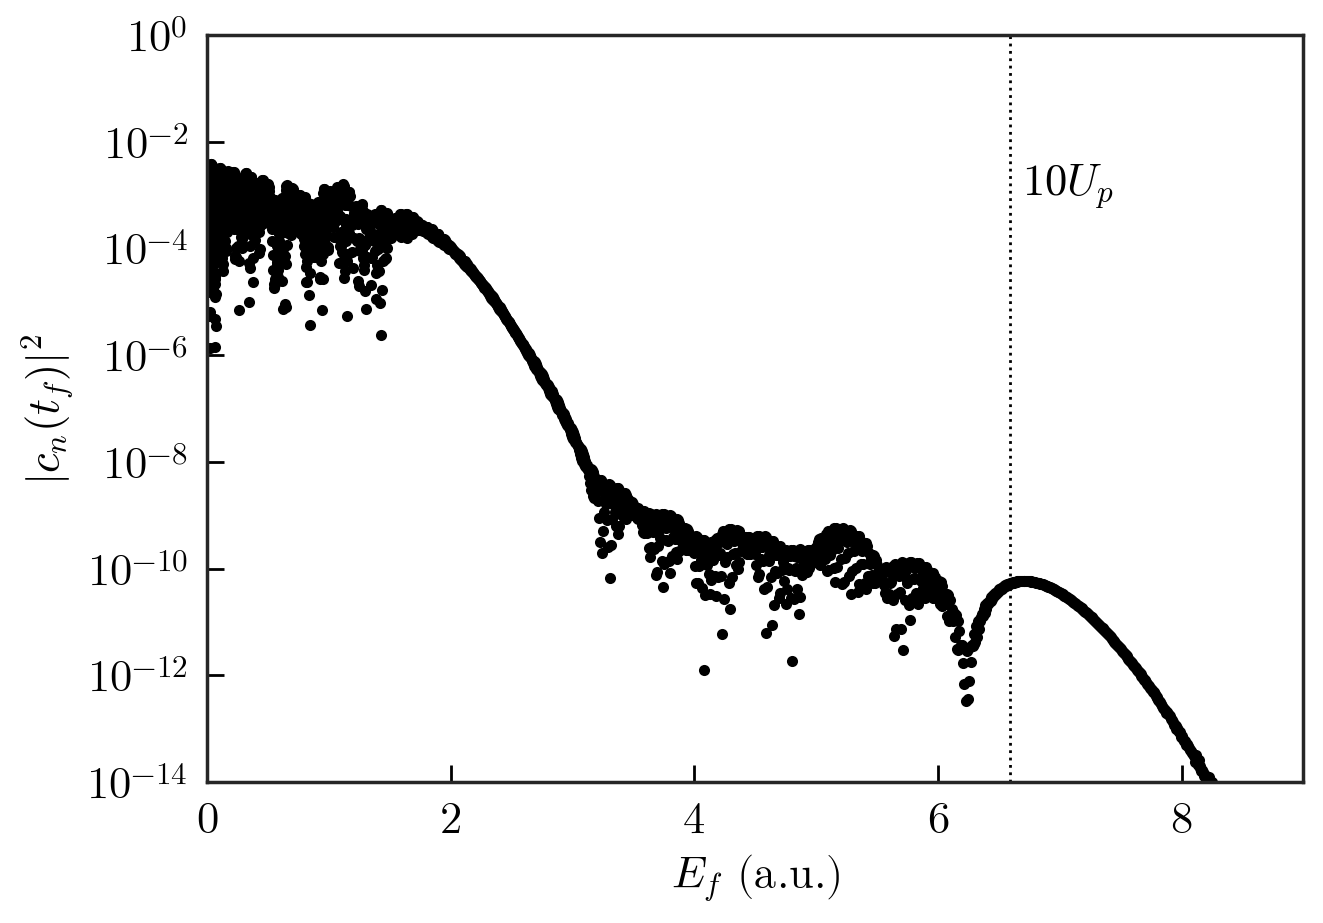

In [22]:
fig, ax = plt.subplots()
ax.plot(sol.vals,abs(sol.psif_E)**2,'o',ms=4,label=r"$|c_n(t_f)|^2$")
ax.set_xlabel(r"$E_f$ (a.u.)")
ax.set_ylabel(r"$|c_n(t_f)|^2$")
ax.set_xlim(0,9)
ax.set_ylim(1e-14,1)
ax.axvline(10*Up,ls=':',lw=1)
ax.text(10*Up+0.1, 1e-3, r"$10 U_p$")
ax.set_yscale("log")